<a href="https://colab.research.google.com/github/Tu-Hanh-Nguyen/Fansipan-Dality-Notes/blob/master/MLE_5_4_One_Layer_NN_16_08_2019_16h40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-Layer Neural Network from scratch




In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1) # set a seed so that the results are consistent

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load the data from h5 file
def load_dataset():
    train_dataset = h5py.File('/content/gdrive/My Drive/CoderSchool-FTMLE/data/datasets/cat_vs_noncat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/gdrive/My Drive/CoderSchool-FTMLE/data/datasets/cat_vs_noncat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

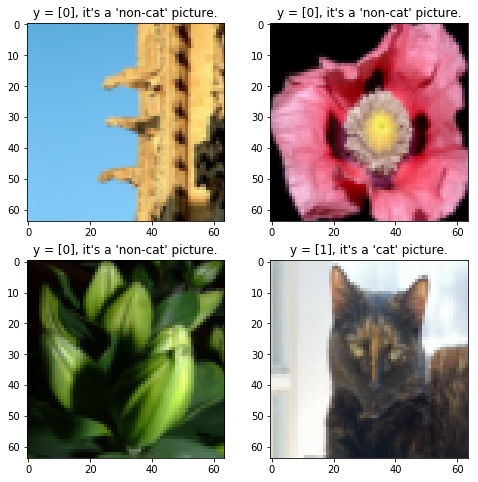

In [0]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_orig)) 
plt.imshow(train_set_x_orig[index_1])
plt.title("y = " + str(train_set_y_orig[:, index_1]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_1])].decode("utf-8") +  "' picture.")

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_2])
plt.title("y = " + str(train_set_y_orig[:, index_2]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_2])].decode("utf-8") +  "' picture.")

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_3])
plt.title("y = " + str(train_set_y_orig[:, index_3]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_3])].decode("utf-8") +  "' picture.")

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_4])
plt.title("y = " + str(train_set_y_orig[:, index_4]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_4])].decode("utf-8") +  "' picture.")

plt.show()

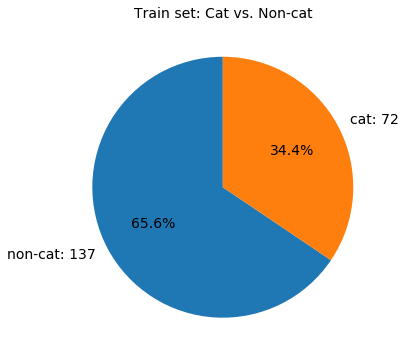

In [0]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['non-cat: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Non-cat', fontdict={'fontsize': 14})
plt.show()

In [0]:
# Convert X to 2D array
X_train = train_set_x_orig.flatten().reshape((len(train_set_x_orig),-1)) / 255
X_test = test_set_x_orig.flatten().reshape((len(test_set_x_orig),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((209, 12288), (1, 209), (50, 12288), (1, 50))

## Building model

We are going to train a Neural Network with a single hidden layer

<img src="https://i.imgur.com/5EHSfO6.png" alt="cat-noncat" width="75%"/>

**Mathematical expression of the algorithm**:

For $i^{th}$ example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost function $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

The general methodology to build a Neural Network is to:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

Define three variables:

    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

### Summary of forward propagation

$Z^{[1]} = W^{[1]}X^T + b^{[1]}$

$A^{[1]} = tanh(Z^{[1]})$

$Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]}$

$A^{[2]} = sigmoid(Z^{[2]})$

$J = -\frac1m\sum \bigg( Y \odot log(A^{[2]}) + (1-Y) \odot log(1-A^{[2]}) \bigg)$

> Note that $\odot$ denotes elementwise multiplication.

In [0]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [0]:
def relu(Z):
    return np.maximum(0, Z)

In [0]:
def relu_backward(Z):
    temp = np.ones(Z.shape)
    temp[Z<0] = 0
    return temp

In [0]:
def layer_sizes(X, Y, n_h):
    n_x = X.shape[1]
    n_h = n_h
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

n_x, n_h, n_y = layer_sizes(X_train, y_train, 4)

In [0]:
def initialize_params(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) / np.sqrt(n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape==(n_h, n_x))
    assert (W2.shape==(n_y, n_h))
    assert (b1.shape==(n_h, 1))
    assert (b2.shape==(n_y, 1))
    
    parameters = {
        'W1': W1,
        'W2': W2,
        'b1': b1,
        'b2': b2
    }
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X.T) + b1
    
    # Use tanh as activate function
    # A1 = np.tanh(Z1)
    
    #Use Relu
    A1 = relu(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    m = X.shape[0]
    assert (A2.shape==(1,m))
    
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return A2, cache


In [0]:
def compute_cross_entropy_cost(A2, Y, parameters):
    m = Y.shape[1]
    
    loss = np.multiply(Y, np.log(A2)) + np.multiply(1-Y, np.log(1-A2))
    J = (-1/m) * np.sum(loss)
    J = np.squeeze(J) # np.squeeze([24]) => 24
    
    return J

### Summary of backward propagation

$dZ^{[2]}= (A^{[2]} -Y)$

$dW^{[2]} = \frac{1}{m} dZ^{[2]}A^{[1]^T} $

$db^{[2]} = \frac{1}{m}np.sum(dZ^{[2]}, axis=1, keepdims=True)$

$dZ^{[1]} =   W^{[2]^T}dZ^{[2]} \odot g^{[1]'}(Z^{[1]})$

$dW^{[1]} = \frac1mdZ^{[1]}X$

$db^{[1]} = \frac{1}{m}np.sum(dZ^{[1]}, axis=1, keepdims=True)$

> Note that $\odot$ denotes elementwise multiplication.

> The notation you will use is common in deep learning coding:
>    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
>    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
>    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
>    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$

> To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - A1**2)`.

In [0]:
def backward_propagation(X, Y, parameters, cache):
    
    m = X.shape[0]
    
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # tanh as activate function
    # dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - A1**2))
    
    # Relu as activate function
    dZ1 = np.multiply(np.dot(W2.T, dZ2), relu_backward(Z1))
    
    dW1 = (1/m)*np.dot(dZ1, X)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dW1":dW1,
        "dW2":dW2,
        "db1":db1,
        "db2":db2
    }
    
    return grads

In [0]:
def update_parameters(parameters, grads, learning_rate):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    dW2 = grads['dW2']
    db1 = grads['db1']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2
    
    parameters = {
        'W1': W1,
        'W2': W2,
        'b1': b1,
        'b2': b2
    }
    
    return parameters

### Build our neural network in `nn_model()`

In [0]:
def nn_model(X, Y, n_h, iterations, learning_rate):
    n_x, n_h, n_y = layer_sizes(X, Y, n_h)
    
    parameters = initialize_params(n_x, n_h, n_y)
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    costs = []
    test_errors = []
    
    for i in range(iterations):
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)
        # Calculate cost
        J = compute_cross_entropy_cost(A2, Y, parameters)
        # Backward propagation
        grads = backward_propagation(X, Y, parameters, cache)
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            print('Iteration %i, Cost: %f' % (i, J))
            costs.append(J)
            A2_test, _ = forward_propagation(X_test, parameters)
            predictions = A2_test > 0.5
            test_errors.append(1 - accuracy_score(y_test[0], predictions[0]))
            
            
    # plot the cost
    fig, ax = plt.subplots(figsize=(6,8))
    plt.plot(costs)
    plt.plot(test_errors, c='r')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
            

In [0]:
def predict(X, parameters):
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    return predictions, A2

Iteration 0, Cost: 0.695046
Iteration 100, Cost: 0.630984
Iteration 200, Cost: 0.608787
Iteration 300, Cost: 0.586808
Iteration 400, Cost: 0.561568
Iteration 500, Cost: 0.533669
Iteration 600, Cost: 0.503898
Iteration 700, Cost: 0.473497
Iteration 800, Cost: 0.444395
Iteration 900, Cost: 0.412018
Iteration 1000, Cost: 0.383407
Iteration 1100, Cost: 0.357232
Iteration 1200, Cost: 0.331951
Iteration 1300, Cost: 0.309522
Iteration 1400, Cost: 0.290536
Iteration 1500, Cost: 0.273161
Iteration 1600, Cost: 0.257015
Iteration 1700, Cost: 0.238227
Iteration 1800, Cost: 0.221064
Iteration 1900, Cost: 0.205749
Iteration 2000, Cost: 0.192266
Iteration 2100, Cost: 0.179488
Iteration 2200, Cost: 0.168079
Iteration 2300, Cost: 0.158053
Iteration 2400, Cost: 0.148572
Iteration 2500, Cost: 0.139939
Iteration 2600, Cost: 0.131887
Iteration 2700, Cost: 0.124657
Iteration 2800, Cost: 0.118208
Iteration 2900, Cost: 0.112053
Iteration 3000, Cost: 0.106311
Iteration 3100, Cost: 0.101085
Iteration 3200, Cost

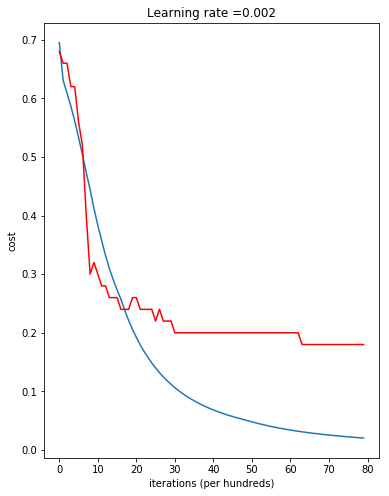

In [0]:
parameters = nn_model(X_train, y_train, n_h=7, iterations=8000, learning_rate=0.002)

predictions, A2 = predict(X_test, parameters)

In [0]:
predictions, A2 = predict(X_train, parameters)
print("Accuracy Score - Training set: %f" % accuracy_score(y_train[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_train[0], predictions[0]))

Accuracy Score - Training set: 1.000000
Confusion Matrix:
[[137   0]
 [  0  72]]


In [0]:
predictions, A2 = predict(X_test, parameters)

print("Accuracy Score: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))

Accuracy Score: 0.820000
Confusion Matrix:
[[13  4]
 [ 5 28]]


In [0]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

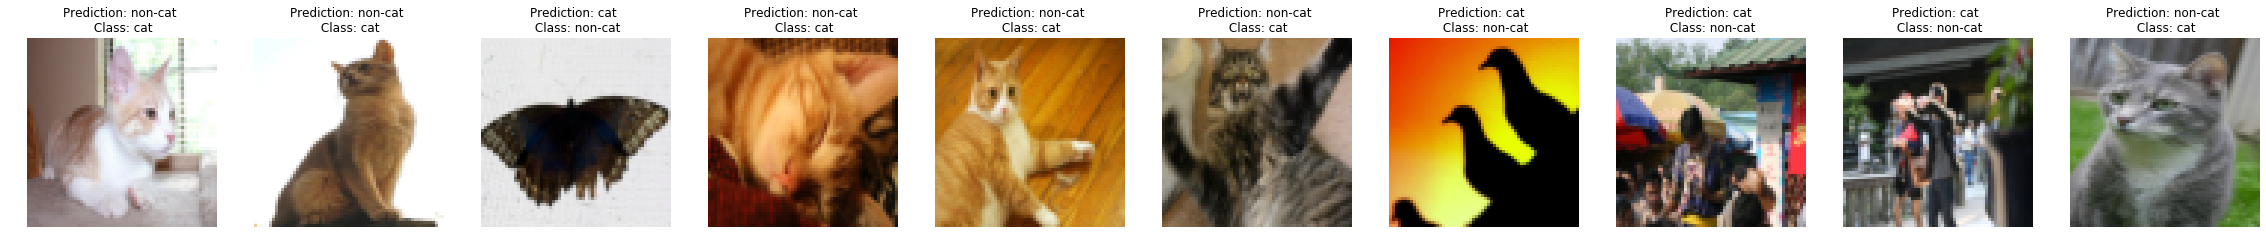

In [0]:
print_mislabeled_images(classes, X_test, y_test, predictions)

## Model from sklearn

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Create Logistics Regression model from X and y
lg = LogisticRegression()
lg.fit(X_train, y_train[0])

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test[0], lg.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], lg.predict(X_test)))

Accuracy Score: 0.720000
Confusion Matrix:
[[13  4]
 [10 23]]
